In [48]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d

In [49]:
SGA_color_params = Table.read('/global/homes/a/amii_mat/DESI_SGA/Morphology/SGA_Concentration_Index.fits')
SGA_color_params

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r(50)_R,r(90)_R,r(50)_G,r(90)_G,r(50)_Z,r(90)_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.30

# Color Gradient

### Using expression for $m(r)$ given in ellipse-fitting model from SGA, where:
###  $m(r_{50}) = m_{tot} + m_0\log_{e}[1 + \alpha_{1}(\frac{r_{50}}{r_0})^{-\alpha_{2}}]$ 
###  $m(r_{90}) = m_{tot} + m_0\log_{e}[1 + \alpha_{1}(\frac{r_{90}}{r_0})^{-\alpha_{2}}]$
### Calculate $\Delta$(g-i) = $(g-i)(r_{50} < r_{90})$ - $(g-i)(r < r_{50})$
### In terms of $m(r_{90})$ and $m(r_{50})$, expression follows: 
### $(i)(r_{50} < r_{90}) = -2.5\log_{10}(\frac{10^\frac{-m(r_{90})}{2.5} -  10^\frac{-m(r_{50})}{2.5}}{10^\frac{-m(r_{50})}{2.5}}))$
### $(i)(r < r_{50}) = m(r_{50})$

In [50]:
# Define values to use
alpha_1_r = SGA_color_params['R_COG_PARAMS_ALPHA1']
alpha_2_r = SGA_color_params['R_COG_PARAMS_ALPHA2']

r90_r = SGA_color_params['r(90)_R']
r50_r = SGA_color_params['r(50)_R']
m0_r = SGA_color_params['R_COG_PARAMS_M0']
r0 = 10.0

In [51]:
# mask mtot values for all bands
SGA_color_params['R_COG_PARAMS_MTOT'][SGA_color_params['R_COG_PARAMS_MTOT'] < 0] = np.NaN
m_tot_r = SGA_color_params['R_COG_PARAMS_MTOT']
SGA_color_params['Z_COG_PARAMS_MTOT'][SGA_color_params['Z_COG_PARAMS_MTOT'] < 0] = np.NaN
m_tot_z = SGA_color_params['Z_COG_PARAMS_MTOT']
SGA_color_params['G_COG_PARAMS_MTOT'][SGA_color_params['G_COG_PARAMS_MTOT'] < 0] = np.NaN
m_tot_g = SGA_color_params['G_COG_PARAMS_MTOT']

In [52]:
# Do calculation for R band m(r90) and m(r50)
power_90 = (r90_r / r0) ** (-alpha_2_r)
power_50 = (r50_r / r0) ** (-alpha_2_r)

inside_log_term90_r = (1.0 + (alpha_1_r * power_90))
inside_log_term50_r = (1.0 + (alpha_1_r * power_50))

m_r90_R = m_tot_r + (m0_r * (np.log(inside_log_term90_r)))
m_r50_R = m_tot_r + (m0_r * (np.log(inside_log_term50_r)))

In [53]:
# Do calculation for delta R between r(90) and r(50)
first_term = 10**((-0.4 * m_r90_R))
second_term = 10**((-0.4 * m_r50_R))
delta_r90_50 = (-2.5) * np.log10((first_term - second_term) / second_term)
print(delta_r90_50)

[0.242275670170784 0.2422729879617691 0.242275670170784 ...
 0.24227283895015717 0.24158108234405518 0.242275670170784]


In [54]:
# Do calculation for Z band m(r90) and m(r50)
alpha_1_z = SGA_color_params['Z_COG_PARAMS_ALPHA1']
alpha_2_z = SGA_color_params['Z_COG_PARAMS_ALPHA2']
r0 = 10.0
r90_z = SGA_color_params['r(90)_Z']
r50_z = SGA_color_params['r(50)_Z']
m0_z = SGA_color_params['Z_COG_PARAMS_M0']

# Do calculation for Z band m(r90) and m(r50)
power_90 = (r90_z / r0) ** (-alpha_2_z)
power_50 = (r50_z / r0) ** (-alpha_2_z)

inside_log_term90_z = (1.0 + (alpha_1_z * power_90))
inside_log_term50_z = (1.0 + (alpha_1_z * power_50))

m_r90_Z = m_tot_z + (m0_z * (np.log(inside_log_term90_z)))
m_r50_Z = m_tot_z + (m0_z * (np.log(inside_log_term50_z)))

In [55]:
# Do calculation for delta Z between r(90) and r(50)
first_term = 10**((-0.4 * m_r90_Z))
second_term = 10**((-0.4 * m_r50_Z))
delta_z90_50 = (-2.5) * np.log10((first_term - second_term) / second_term)
print(delta_z90_50)

[0.2422783374786377 0.24227291345596313 0.24227291345596313 ...
 0.2422783374786377 0.24135056138038635 0.24227574467658997]


In [56]:
# Do calculation for G band m(r90) and m(r50)
alpha_1_g = SGA_color_params['G_COG_PARAMS_ALPHA1']
alpha_2_g = SGA_color_params['G_COG_PARAMS_ALPHA2']
r0 = 10.0
r90_g = SGA_color_params['r(90)_G']
r50_g = SGA_color_params['r(50)_G']
m0_g = SGA_color_params['G_COG_PARAMS_M0']

# Do calculation for G band m(r90) and m(r50)
power_90 = (r90_g / r0) ** (-alpha_2_g)
power_50 = (r50_g / r0) ** (-alpha_2_g)

inside_log_term90_g = (1.0 + (alpha_1_g * power_90))
inside_log_term50_g = (1.0 + (alpha_1_g * power_50))

m_r90_G = m_tot_g + (m0_g * (np.log(inside_log_term90_g)))
m_r50_G = m_tot_g + (m0_g * (np.log(inside_log_term50_g)))

In [57]:
# Do calculation for delta G between r(90) and r(50)
first_term = 10**((-0.4 * m_r90_G))
second_term = 10**((-0.4 * m_r50_G))
delta_g90_50 = (-2.5) * np.log10((first_term - second_term) / second_term)
print(delta_g90_50)

[0.242275670170784 0.24227291345596313 0.24227574467658997 ...
 0.24227581918239594 0.24337558448314667 0.24227574467658997]


In [58]:
# Actual gradients between m(r90) and m(r50), these are the tiny values
Grad_gz_r90_50 = delta_g90_50 - delta_z90_50
Grad_gr_r90_50 = delta_g90_50 - delta_r90_50
Grad_rz_r90_50 = delta_r90_50 - delta_z90_50

In [66]:
# Change in magnitude between m(r50) for every gradient
difference_mr50_G_Z = m_r50_G - m_r50_Z
difference_mr50_G_R = m_r50_G - m_r50_R
difference_mr50_R_Z = m_r50_R - m_r50_Z

# Actual Color gradient calculation:
Color_grad_g_z = Grad_gz_r90_50 - difference_mr50_G_Z 
Color_grad_g_r = Grad_gr_r90_50 - difference_mr50_G_R
Color_grad_r_z = Grad_rz_r90_50 - difference_mr50_R_Z

np.unique(Color_grad_r_z)
# This gives values from roughly -5 to 5, which we know it shouldn't, but I can't pinpoint
# where it is going wrong.

-4.9798613
-4.884553
-4.3731437
-4.0657234
-3.9989336
-3.9465876
-3.7747478
-3.736031
-3.6187446
-3.5904436
-3.3832614


In [62]:
SGA_color_params.add_column(col=Color_grad_g_z, name ="GRADIENT_G-Z")
SGA_color_params.add_column(col=Color_grad_g_r, name ="GRADIENT_G-R")
SGA_color_params.add_column(col=Color_grad_r_z, name ="GRADIENT_R-Z")
SGA_color_params

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r(50)_R,r(90)_R,r(50)_G,r(90)_G,r(50)_Z,r(90)_Z,DELTA_G_r50/90,DELTA_R_r50/90,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,

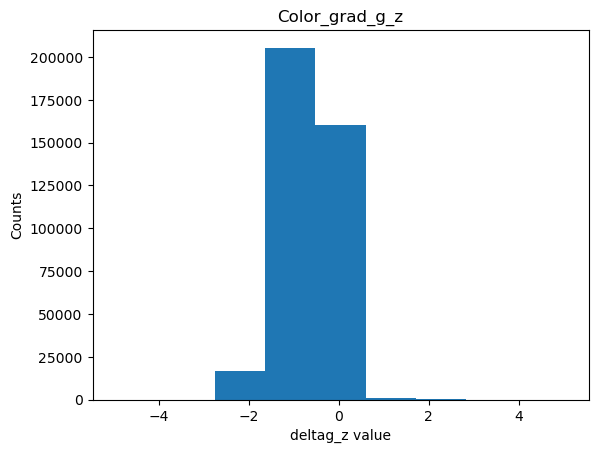

In [69]:
plt.hist(Color_grad_r_z, bins=9)
plt.title('Color_grad_r_z')
plt.ylabel('Counts')
plt.xlabel('deltar_z value')
plt.show()

In [71]:
Calculated_params = Table([SGA_color_params['COLOR G-Z'], SGA_color_params['COLOR G-R'], SGA_color_params['COLOR R-Z'], SGA_color_params['C_INDEX_G_r50_r90'], 
                           SGA_color_params['C_INDEX_R_r50_r90'], SGA_color_params['C_INDEX_Z_r50_r90'], SGA_color_params['GRADIENT_G-Z'], 
                           SGA_color_params['GRADIENT_G-R'], SGA_color_params['GRADIENT_R-Z']])
Calculated_params

COLOR G-Z,COLOR G-R,COLOR R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z
float32,float32,float32,float32,float32,float32,float32,float32,float32
1.4698534,0.8453007,0.6245527,0.36926162,0.3569853,0.37169367,-1.4638555,-0.83885384,-0.6250017
1.0503893,0.59065247,0.45973682,0.40545705,0.40201306,0.3737081,-1.04947,-0.58032995,-0.46914
1.0703144,0.61769104,0.45262337,0.4497225,0.44100803,0.41019368,-1.0891199,-0.6139278,-0.4751922
1.8140249,1.015461,0.79856396,0.36959928,0.3623396,0.3578335,-1.8038503,-1.0040095,-0.7998408
1.4162283,0.9283848,0.4878435,0.2658225,0.24351266,0.26247093,-1.347269,-0.93085194,-0.41641718
0.6405144,0.41829872,0.22221565,0.41869116,0.4040002,0.42624477,-0.57833093,-0.41708955,-0.16124137
--,--,--,--,--,--,--,--,--
0.9809294,0.5707226,0.4102068,0.4763662,0.48017228,0.48605445,-0.9644116,-0.56273806,-0.4016736
1.8268623,1.1893864,0.63747597,0.21646589,0.18029338,0.27855292,-1.7069348,-1.1984215,-0.50851333
